# Keras Functional API

In [1]:
# https://www.tensorflow.org/guide/keras/functional

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
import numpy as np
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## Input and output layers for the model

In [2]:
inputs = keras.Input(shape=(784,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10)(x)

In [3]:
inputs.shape, inputs.dtype

(TensorShape([None, 784]), tf.float32)

In [4]:
outputs.shape, outputs.dtype

(TensorShape([None, 10]), tf.float32)

In [5]:
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

## Model summaries 

In [6]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


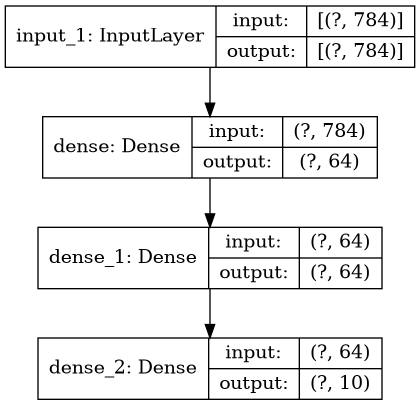

In [7]:
keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

## Training, evaluation and inference

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=2,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 4s 88us/sample - loss: 0.3389 - accuracy: 0.9043 - val_loss: 0.1750 - val_accuracy: 0.9501
Epoch 2/2
48000/48000 [==============================] - 4s 75us/sample - loss: 0.1528 - accuracy: 0.9551 - val_loss: 0.1441 - val_accuracy: 0.9574
10000/10000 - 1s - loss: 0.1317 - accuracy: 0.9601
Test loss: 0.1317267452875152
Test accuracy: 0.9601


## Saving the model

In [9]:
model.save('model.save')
del model
model = keras.models.load_model('model.save')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model.save/assets


## Reusing intermediate layers

In [10]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()
#keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [11]:
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()
#keras.utils.plot_model(autoencoder, 'autoencoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                

## Models as layers

In [12]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)
decoder = keras.Model(decoder_input, decoder_output, name='decoder')

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


## Ensembling models

In [13]:
def get_model():
  inputs = keras.Input(shape=(128,))
  outputs = layers.Dense(1)(inputs)
  return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

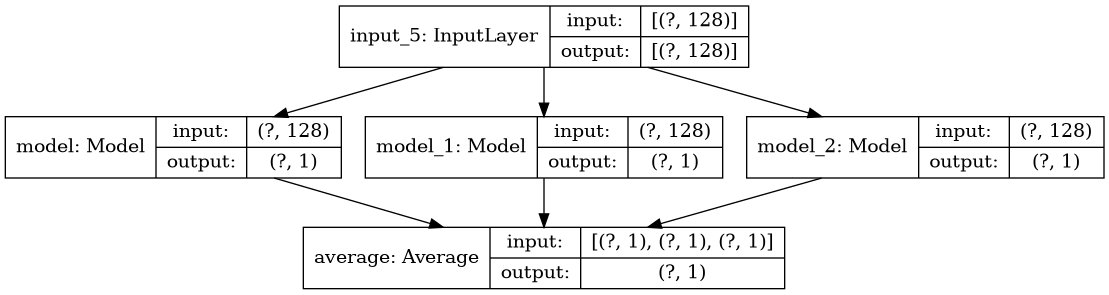

In [14]:
keras.utils.plot_model(ensemble_model, 'ensemble_model.png', show_shapes=True)

## Multiple inputs, multiple outputs

Let's say you're building a system for ranking custom issue tickets by priority and routing them to the right department.

You model will have 3 inputs:

- Title of the ticket (text input)
- Text body of the ticket (text input)
- Any tags added by the user (categorical input)

It will have two outputs:

- Priority score between 0 and 1 (scalar sigmoid output)
- The department that should handle the ticket (softmax output over the set of departments)

In [15]:
num_tags = 3  # Number of unique issue tags
num_words = 50  # Size of vocabulary obtained when preprocessing text data
num_departments = 2  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name='tags')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 32-dimensional vector
title_features = layers.Embedding(num_words, 32)(title_input)
# Embed each word in the text into a 32-dimensional vector
body_features = layers.Embedding(num_words, 32)(body_input)

# Reduce sequence of embedded words in the title into a single 64-dimensional vector
title_features = layers.LSTM(64)(title_features)
# Reduce sequence of embedded words in the body into a single 16-dimensional vector
body_features = layers.LSTM(16)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name='priority')(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])

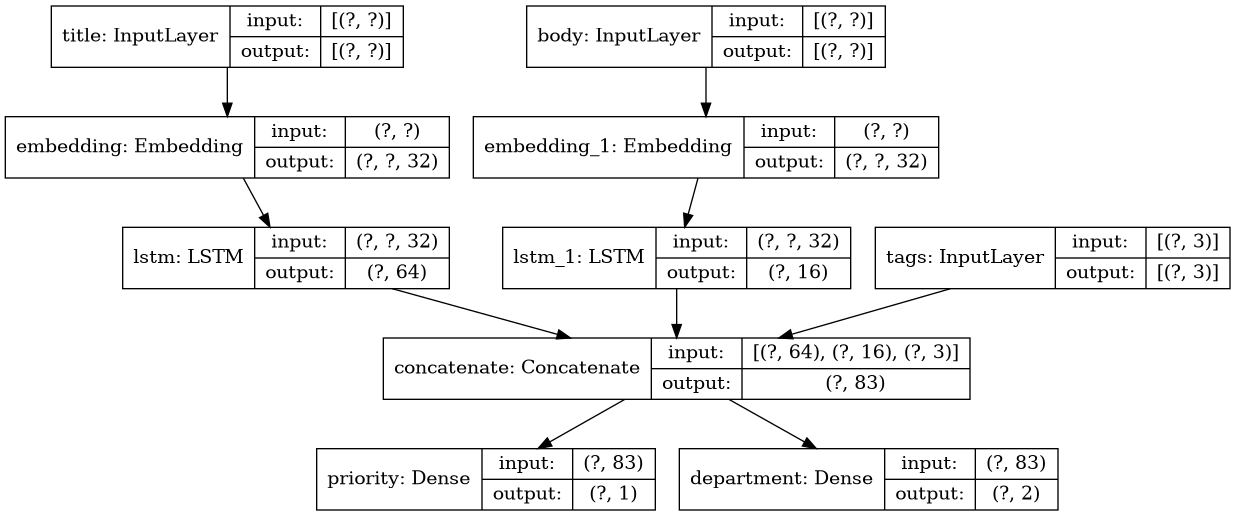

In [16]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [17]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'priority':keras.losses.BinaryCrossentropy(from_logits=True),
                    'department': keras.losses.CategoricalCrossentropy(from_logits=True)},
              loss_weights=[1., 0.2])

In [18]:
# Dummy input data
title_data = np.random.randint(num_words, size=(32, 5))
body_data = np.random.randint(num_words, size=(32, 25))
tags_data = np.random.randint(2, size=(32, num_tags)).astype('float32')
# Dummy target data
priority_targets = np.random.random(size=(32, 1))
dept_targets = np.random.randint(2, size=(32, num_departments))

model.fit({'title': title_data, 'body': body_data, 'tags': tags_data},
          {'priority': priority_targets, 'department': dept_targets},
          epochs=2,
          batch_size=8)

Train on 32 samples
Epoch 1/2
32/32 [==============================] - 4s 133ms/sample - loss: 0.8440 - priority_loss: 0.7009 - department_loss: 0.7155
Epoch 2/2
32/32 [==============================] - 0s 1ms/sample - loss: 0.8378 - priority_loss: 0.6958 - department_loss: 0.7104


## Non sequential layers

In [19]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name='toy_resnet')

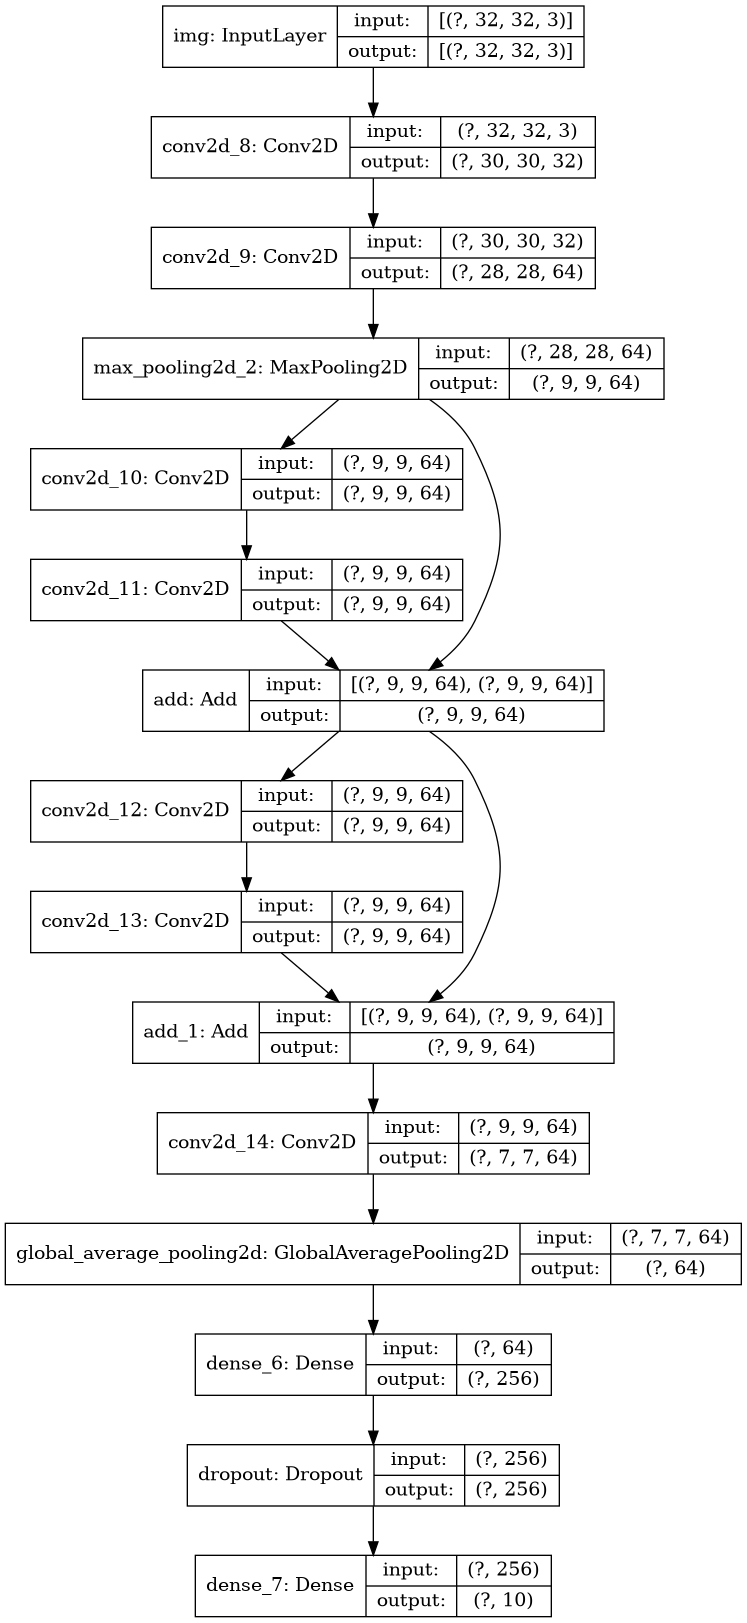

In [20]:
keras.utils.plot_model(model, 'mini_resnet.png', show_shapes=True)

In [21]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc'])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 21s 518us/sample - loss: 1.9093 - acc: 0.2783 - val_loss: 1.5872 - val_acc: 0.4029


## Sharing layers

In [22]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype='int32')

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype='int32')

# We reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## Extracting nodes in a graph

In [23]:
model = MobileNetV2()

In [24]:
features_list = [layer.output for layer in model.layers]

In [25]:
len(features_list)

157

In [26]:
features_list = features_list[10:11]

In [27]:
feat_extraction_model = keras.Model(inputs=model.input, outputs=features_list)

In [28]:
feat_extraction_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
bn_Conv1 (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
Conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
expanded_conv_depthwise (Dep (None, 112, 112, 32)      288       
_________________________________________________________________
expanded_conv_depthwise_BN ( (None, 112, 112, 32)      128 

In [29]:
img = np.random.random((1, 224, 224, 3)).astype('float32')
extracted_features = feat_extraction_model(img)

In [30]:
extracted_features[0][0]

<tf.Tensor: shape=(112, 96), dtype=float32, numpy=
array([[-1.4922727 , -2.6519914 ,  6.673541  , ...,  2.735897  ,
         0.16953361, -1.0026501 ],
       [ 2.4977922 , -4.517949  , -3.8720074 , ...,  4.8583508 ,
        -4.618996  ,  3.2040834 ],
       [ 0.93739396, -3.7053065 ,  0.5672227 , ...,  4.434264  ,
        -4.1619134 ,  1.0788076 ],
       ...,
       [ 0.07342625, -2.5513453 ,  3.0402374 , ...,  3.3144379 ,
        -3.189632  ,  2.3436792 ],
       [ 1.8034978 , -3.8637507 , -2.0660844 , ...,  4.2903576 ,
        -5.1449375 ,  1.6820524 ],
       [ 5.348732  , -6.743646  , -9.316846  , ...,  4.078724  ,
        -4.930215  ,  2.3346608 ]], dtype=float32)>

## Custom layers

In [31]:
# https://www.tensorflow.org/guide/keras/custom_layers_and_models

class CustomDense(layers.Layer):

  def __init__(self, units=32):
    super(CustomDense, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

  def get_config(self):
    return {'units': self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(
    config, custom_objects={'CustomDense': CustomDense})

## Final considerantions

Strengths of the Functional API:
- It is less verbose.
- It validates your model while you're defining it.
- Your Functional model is plottable and inspectable.
- Your Functional model can be serialized or cloned.

Weaknesses of the Functional API:
- It does not support dynamic architectures (e.g. recursive networks or Tree RNNs cannot be implemented in the Functional API).
- Sometimes, you just need to write everything from scratch.